In [ ]:
# ! pip install stats

In [25]:
i = Image.open('/workspace/submission/paper_2/fuse/Vander Henst_L.pdf_dir/2_Vander Henst_L.pdf.jpg')
i = i.resize((2592, 1728))
i.save('t.png')

In [22]:
from pdfminer.layout import LAParams, LTTextBox, LTCurve, LTLine, LTFigure
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
import cv2
from PyPDF2 import PdfReader
import io
from pdf2jpg import pdf2jpg
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import stats
import pandas as pd
from PIL import Image

In [2]:
w, h = 1728, 2592
image = np.zeros((w, h), dtype='uint8')

In [3]:
dims = np.load('npys/dims_2_Vander Henst_L.npy')
lines = np.load('npys/lines_2_Vander Henst_L.npy')
lenghts = np.sqrt((lines.T[0]-lines.T[2])**2 + (lines.T[1]-lines.T[3])**2)
lines = np.c_[lines, lenghts]

In [11]:
pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'text'], data=dims[:5])

,x1,y1,x2,y2,text
0,2264.04234374688,1393.44,2270.28234374688,1398.11712,"4"""
1,2264.04234374688,1379.16,2270.28234374688,1387.6204800000003,8-'9
2,409.32234374688,1213.68,415.56234374688,1218.35712,"4"""
3,409.32234374688,1081.44,415.56234374688,1088.99712,"42"""
4,2264.04234374688,1224.48,2270.28234374688,1229.15712,"8"""


In [12]:
pd.DataFrame(columns=['x1', 'y1', 'x2', 'y2', 'width', 'length'], data=lines[:5])

,x1,y1,x2,y2,width,length
0,2438.04,111.6,2438.04,116.04,4.0,4.44
1,2545.80,111.6,2545.80,54.00,4.0,57.60
2,2545.80,54.0,2438.04,54.00,4.0,107.76
3,2438.04,54.0,2438.04,111.60,4.0,57.60
4,2438.04,111.6,2545.80,111.60,4.0,107.76


In [13]:
def point_dist(p1, p2):
    return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

In [21]:
zero_width = lines.T[-2]==0

line_indices = []
per_pixel_inches = []
for d in dims:
    c = (float(d[0]) + float(d[2]))/2, (float(d[1]) + float(d[3]))/2
    dists = []
    for l in lines:
        p1 = l[0], l[1]
        p2 = l[2], l[3]
        dists.append(point_dist(c, p1))
        dists.append(point_dist(c, p2))
    l0, l1 = sorted(dists)[:2]
    line_indices.append(dists.index(l0)//2)
    line_indices.append(dists.index(l1)//2)
    len1 = lenghts[dists.index(l0)//2]
    len2 = lenghts[dists.index(l1)//2]
    line1 = lines[dists.index(l0)//2]
    line2 = lines[dists.index(l1)//2]
    
    p1, p2 = (line1[0], line1[1]), (line1[2], line1[3])
    p3, p4 = (line2[0], line2[1]), (line2[2], line2[3])
    
    final_dist = max(point_dist(p1, p3), point_dist(p1, p4), point_dist(p2, p3), point_dist(p2, p4))
    len_ratio = abs(1-(len1/len2))
    if len_ratio<1e-2 and "'" in d[-1]:
        if not d[-1] == "'":
            feet = d[-1].split("'")[0]
            inches = d[-1].split("'")[1]
            inches = inches.replace('-', '')
            inches = inches.replace('"', '')
            if inches == '': inches = '0'
            if feet.isnumeric():
                inches = inches.split(' ')
                frac = 0
                if len(inches)>1: 
                    frac = inches[1]
                    frac = int(frac.split('/')[0])/int(frac.split('/')[1])
                inches = int(inches[0]) + frac
                tot_inches = (int(feet)*12) + inches
                txt = d[-1].replace('\t', ' ')
                print(f"{txt}\t\t\t{tot_inches:.2f}\t{final_dist:.2f}\t{tot_inches/final_dist:.2f}")
                per_pixel_inches.append(tot_inches/final_dist)

28'			336.00	504.00	0.67
28'			336.00	504.00	0.67
14'			168.00	252.00	0.67
34'			408.00	612.00	0.67
35'			420.00	630.00	0.67
2'-8"			32.00	1.08	29.63
13'			156.00	234.00	0.67
13'-9 1/2"			165.50	248.28	0.67
3'-9 1/2"			45.50	2.28	19.96
2'-6"			30.00	45.00	0.67
13'-7 1/2"			163.50	5.40	30.28
3'-9"			45.00	67.56	0.67
2'-8"			32.00	6.72	4.76
3'-6"			42.00	6.84	6.14
5'			60.00	90.00	0.67
2'-8"			32.00	6.72	4.76
18'-7"			223.00	334.56	0.67
6'			72.00	108.00	0.67
4'-8"			56.00	84.00	0.67
2'			24.00	216.02	0.11
8'			96.00	144.00	0.67
12'-3"			147.00	220.44	0.67
12'-9"			153.00	229.56	0.67
28'			336.00	504.00	0.67
28'			336.00	504.00	0.67
30'			360.00	540.00	0.67
2'			24.00	215.94	0.11
12'			144.00	216.00	0.67
6'			72.00	108.00	0.67
18'			216.00	324.00	0.67


In [6]:
stats.mode(np.array(per_pixel_inches))

0.6666666666666666

In [33]:
((998-493)*2/3)/12

28.055555555555557

In [36]:
((490-418)*2/3)/12

4.0

In [28]:
((1160-656)*2/3)/12

28.0

In [30]:
((528-456)*2/3)/12

4.0

In [ ]:
# 2/3 inches == 1 pixel
# 656-1160

In [8]:
per_pixel_inches

[0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 29.629629629631626,
 0.6666666666666666,
 0.6665861124536814,
 19.956140350877433,
 0.6666666666666666,
 30.277777777777267,
 0.6660746003552392,
 4.761904761904823,
 6.140350877192954,
 0.6666666666666666,
 4.761904761904823,
 0.6665471066475369,
 0.6666666666666666,
 0.6666666666666666,
 0.11110286442985536,
 0.6666666666666666,
 0.6668481219379422,
 0.666492420282279,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666,
 0.1111418337253251,
 0.6666666666666666,
 0.6666666666666666,
 0.6666666666666666]

In [20]:
cv2.imwrite('a2.png', image)

True

In [49]:
line_indices = []
for d in dims:
    c = (float(d[0]) + float(d[2]))/2, (float(d[1]) + float(d[3]))/2
    dists = []
    for l in lines:
        p1 = l[0], l[1]
        p2 = l[2], l[3]
        dists.append(point_dist(c, p1))
        dists.append(point_dist(c, p2))
    l0, l1 = sorted(dists)[:2]
    line_indices.append(dists.index(l0)//2)
    line_indices.append(dists.index(l1)//2)

In [50]:
# dlines = lines[list(set(line_indices))]
# for l in dlines:
#     p1 = int(l[0]), w-int(l[1])
#     p2 = int(l[2]), w-int(l[3])
#     image = cv2.line(image, p1, p2, 255, 2, 1)

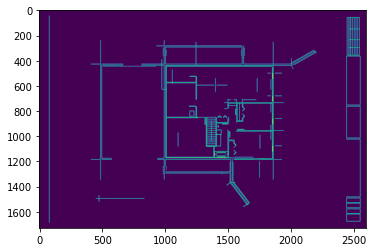

In [51]:
plt.imshow(image)

In [52]:
values_1 = []
values_2 = []
d = dict(Counter(lines.T[0]))
values_1 += [k for k, v in d.items() if v>50]
# d0 = sorted(d.items(), key = lambda x:x[1], reverse=True)
d = dict(Counter(lines.T[1]))
values_1 += [k for k, v in d.items() if v>50]
# d1 = sorted(d.items(), key = lambda x:x[1], reverse=True)
d = dict(Counter(lines.T[2]))
values_2 += [k for k, v in d.items() if v>50]
# d2 = sorted(d.items(), key = lambda x:x[1], reverse=True)
d = dict(Counter(lines.T[3]))
values_2 += [k for k, v in d.items() if v>50]
# d3 = sorted(d.items(), key = lambda x:x[1], reverse=True)

In [53]:
len(set(values_1)), len(set(values_2))

(74, 43)

In [54]:
dashes = np.isin(lines.T[0], values_1)
dlines = lines[dashes]
for l in dlines:
    p1 = int(l[0]), w-int(l[1])
    p2 = int(l[2]), w-int(l[3])
    image = cv2.line(image, p1, p2, 255, 2, 1)
    
dashes = np.isin(lines.T[1], values_2)
dlines = lines[dashes]
for l in dlines:
    p1 = int(l[0]), w-int(l[1])
    p2 = int(l[2]), w-int(l[3])
    image = cv2.line(image, p1, p2, 255, 2, 1)

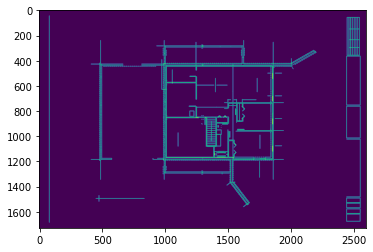

In [55]:
plt.imshow(image)

In [56]:
cv2.imwrite('a2.png', image)

True